In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
from os import listdir
from os.path import splitext, isfile, isdir
from imagemanager import ImageManager
from processing import AstroImageProcessing
from pyplot_utils import show_image, show_image_3d, show_images

import cv2
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max

In [3]:
def load_speckle_images(image_files):
    imager = ImageManager()
    tab =  [roi for roi in [AstroImageProcessing.find_roi(imager.read_image(file)) for file in image_files] if roi is not None]
    max_w = 0
    max_h = 0
    for im in tab:
        (h, w) = im.shape
        max_w = max(w, max_w)
        max_h = max(h, max_h)

    output = []
    for index, im in enumerate(tab):
        if tab[index] is not None and len(tab[index]>0):
            output.append(AstroImageProcessing.resize_with_padding(im, max_w, max_h))
    return output

In [28]:
#image = cv2.imread("results/stf2380_output.png")
image = cv2.imread("trainingset/cou619_output.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

ret, thresh = cv2.threshold(image, image.mean()*0.5, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
ellipse = cv2.fitEllipse(contours[0])
centre, axes, angle = ellipse
angle

155.71107482910156

In [29]:

path = 'imagesrepo/stf2380'
image_files=[]
for file in listdir(path):
    file_path = path + '/' + file
    if isfile(file_path) and splitext(file_path)[1]=='.fit':
        image_files.append(file_path)
speckle_images = load_speckle_images(image_files)

processed=[]

for im in speckle_images:
    image = im.copy()
    #image = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    image = ((image-image.min())/(image.max()-image.min())*255).astype(np.uint8)
    ret, thresh = cv2.threshold(image, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    contours = [sorted_contours[0]]
    #image = cv2.drawContours(image, contours, -1, (255), 3)
    ellipse = cv2.fitEllipse(contours[0])
    centre, axes, c_angle = ellipse
    dist = abs(c_angle - angle)
    cv2.ellipse(image,ellipse,(0,255,0),2)
    processed.append([image,dist])
    


In [30]:
best_images_tab = sorted(processed, key=lambda x: x[1])
best_images = []
for i in range(1000):
    best_images.append(best_images_tab[i][0])

C:\Users\eniquet\dev\speckles-interferometry\pyplot_utils.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(max//column, column)


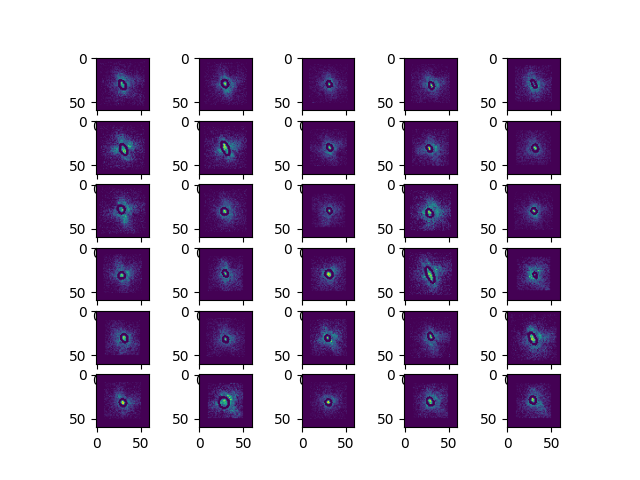

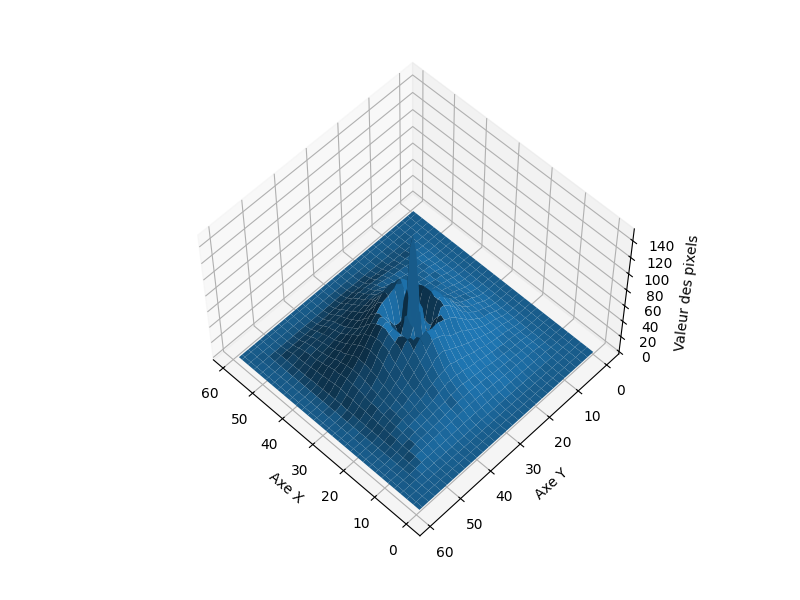

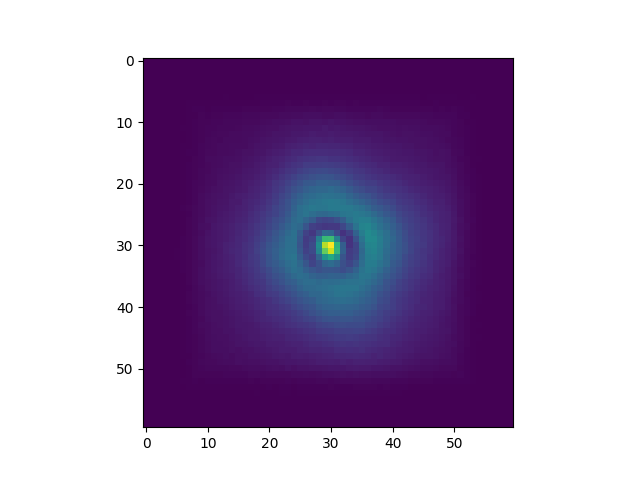

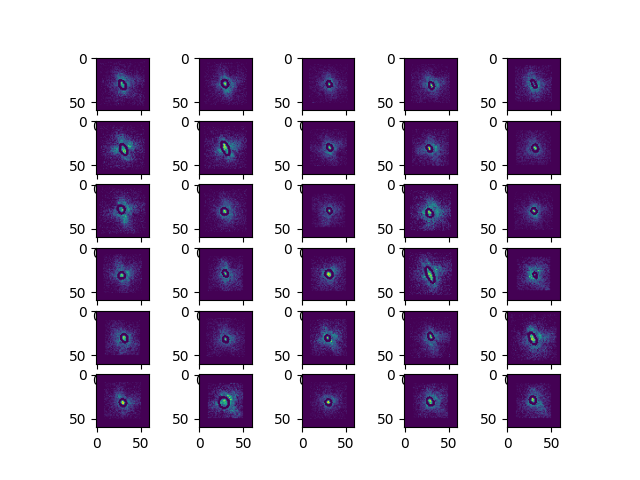

In [32]:
%matplotlib widget
show_images(best_images,max_images=30)
#for im in speckle_images:
#    show_image_3d(im)
im = np.mean(best_images, axis=0)
show_image_3d(im)
show_image(im)
im_bkp = im.copy()


In [33]:
im = im_bkp.copy()

grad_x = cv2.Sobel(im, cv2.CV_64F, 1, 0, ksize=3)
grad_y = cv2.Sobel(im, cv2.CV_64F, 0, 1, ksize=3)
# Calculer la magnitude et l'angle du gradient
magnitude = np.sqrt(grad_x**2 + grad_y**2)
angle = np.arctan2(grad_y, grad_x) * (180 / np.pi)

# Trouver le centre de l'image
centre_y, centre_x = np.array(image.shape) // 2

# Analyser un voisinage autour du centre pour trouver la direction de la pente la plus faible
radius = 5  # Ajuster la taille du voisinage
min_mag = np.inf
min_direction = None

for i in range(-radius, radius + 1):
    for j in range(-radius, radius + 1):
        y, x = centre_y + i, centre_x + j
        if 0 <= y < im.shape[0] and 0 <= x < im.shape[1]:
            if magnitude[y, x] < min_mag:
                min_mag = magnitude[y, x]
                min_direction = angle[y, x]
print(f"Direction de la pente la plus faible : {min_direction} degrés")


Direction de la pente la plus faible : -76.93243344700721 degrés


269.9314447040211
Point où le gradient commence à augmenter : (29.55192638387083, 30.893996663600557)


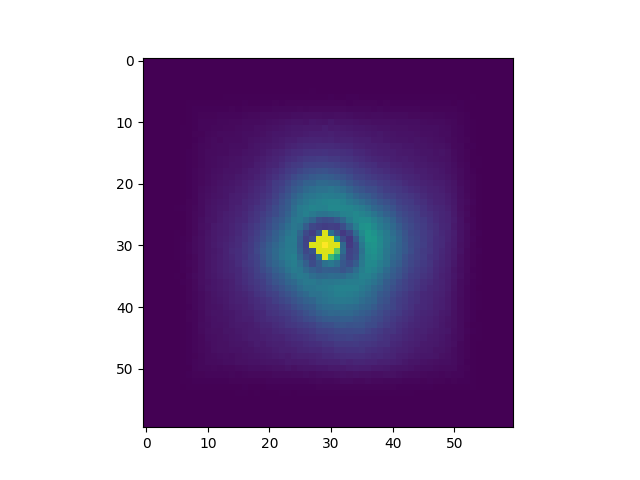

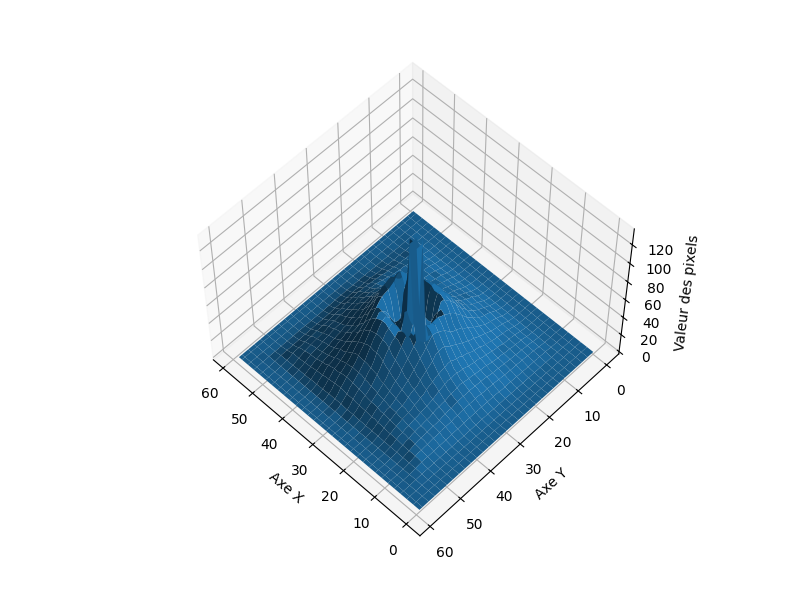

In [35]:

# Se déplacer dans la direction de la pente la plus faible
y, x = centre_y, centre_x
previous_mag = magnitude[y, x]
step_size = 1  # Taille du pas, peut être ajustée

while True:
    y += (step_size * np.sin(direction))
    x += (step_size * np.cos(direction))
    
    if not (0 <= y < image.shape[0] and 0 <= x < image.shape[1]):
        break  # Arrêter si hors des limites de l'image
    current_mag = magnitude[int(y), int(x)]
    print(current_mag)
    if current_mag > previous_mag:
        break  # Trouvé un point où le gradient augmente

    previous_mag = current_mag

print(f"Point où le gradient commence à augmenter : ({x}, {y})")

cv2.circle(im,(int(x),int(y)),1,127,1)
show_image(im)
show_image_3d(im)